## ECE495 Intro to programming neurons with Nengo

In this demonstration we will:

1. Represent a constant input value with a single neuron using Nengo
2. Understand output plots from Nengo (raster plots, decoded neural responses, tuning curves, and more)
3. Tune parameters to understand how to better represent different inputs values using one neuron
4. Repeat 1-3 with 10 neurons
5. Repeat for various time-varying input signals.

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot
from scipy.stats import norm

### Represent (i.e. Encode) Input Data using One Neuron

To do anything with data in Nengo, we must first convert the input data into spiking data using Nengo neuron ensembles. This is biologically inspired: neural populations represent time-varying signals through their spiking responses (recall the human visual system).

We start with a Nengo node that provides the input to a neuron in our Nengo model - this is essentially just a way to pass data from regular Python into a Nengo model filled with neurons. The Nengo neuron then converts the data to spikes (i.e. the neuron encodes the input data). We can then check to see how well our Nengo neuron can represent our input data by decoding the spikes.

Key terms:
- Encode: convert data to spikes
- Decode: convert spikes to numeric values (hopefully looks like our input)

To understand how Nengo neurons encode inputs, we will first look at a single neuron encoding a constant value.

#### Create your input

Start with a positive value between 0 and 1.

In [2]:
nengo_inp = .5

#### Create your model

Every Nengo network requires a model. The model holds all of your nodes, neurons, connections, probes, and other functionality. 

In [3]:
model = nengo.Network(label="Representation")

#### Add to your model

You can adjust or add onto your model anytime using the same `with model:` command. 

In [4]:

# Create a model to perform the sorting
with model:

    # Add input node 
    input_node = nengo.Node(nengo_inp)

    # Add a single neuron to encode the input
    input_neuron = nengo.Ensemble(n_neurons=1, dimensions=1,
        # Set your intercept (where the neuron starts spiking)
        # uniform = values uniformly distributed 
        # between the first and second input, one for each neuron. 
        # If you want a specific value, set both inputs to same value.
        intercepts=Uniform(0,0),
        # Set the maximum firing rate of the neuron (Hz)
        max_rates=Uniform(100,100),
        # Set the neuron's firing rate to increase for values 
        # higher than (1) or lower than  (-1) your intercept
        # Values farther from the intercept elicit higher spike rates
        encoders=[[1]])

    # Connect the node to the encoding neuron
    inp_conn = nengo.Connection(input_node, input_neuron)

    ## Add probes to see outputs throughout the model
    # This probe captures the non-spiking input value
    input_probe_node = nengo.Probe(input_node)

    # This probe displays the decoded neural representation of the input
    input_probe_neuron = nengo.Probe(input_neuron, synapse=0.01)

    # This probe captures the actual spikes from the neuron
    spikes = nengo.Probe(input_neuron.neurons)

    # These probes captures the neuron potential    
    membranePotential = nengo.Probe(input_neuron.neurons, "voltage")

#### Run your model

Once you've built it, it's time to see what it can do.

In [5]:
# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


#### Analyze your model outputs

Plot the outputs collected from Nengo probes. 

(0.0, 1.0)

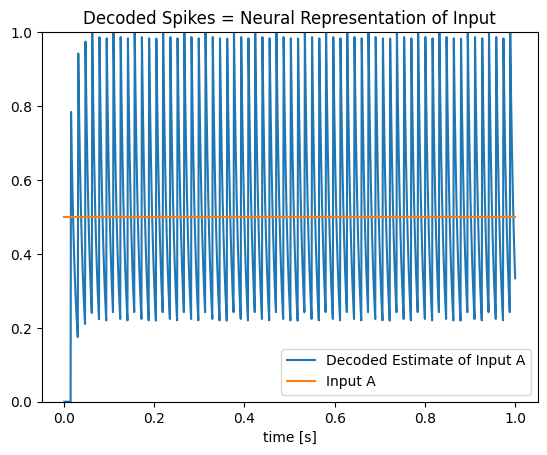

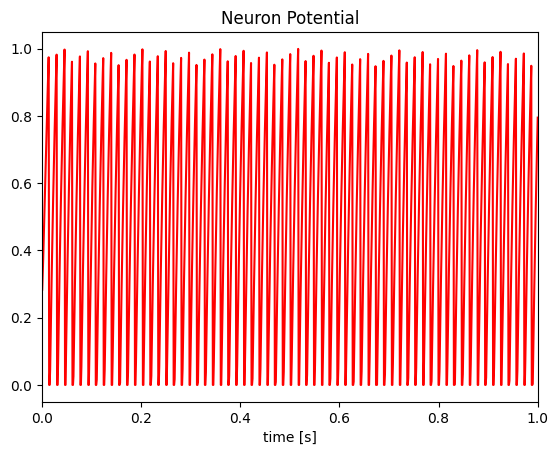

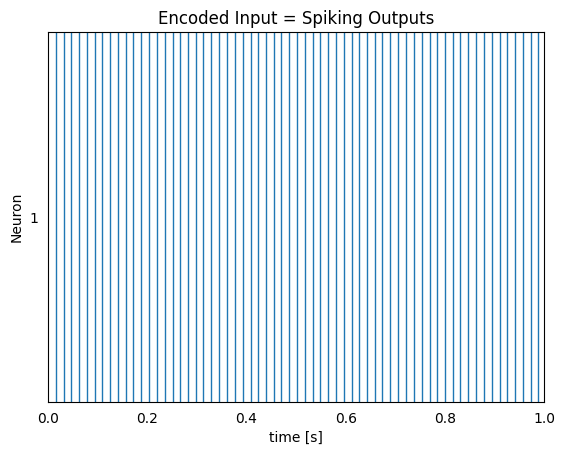

In [6]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")

# Plot the soma voltages of the neurons
plt.figure()
plt.plot(sim.trange(), sim.data[membranePotential][:, 0], "r")
plt.xlim(0, 1)
plt.xlabel("time [s]")
plt.title("Neuron Potential")

# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlabel("time [s]")
plt.title("Encoded Input = Spiking Outputs")
plt.xlim(0, 1)

We can see that this single neuron cannot perfectly represent our input value. We could fine tune parameters to a specific value to get it to perfectly represent it; however, that's not generalizable. BUT! **We will still do that to see how the parameters really affect representations (soon).**

We would expect constant spikes evenly spaced as we are sending in a constant value. We would expect more spikes for larger values, fewer for smaller values.

We can see that the membrane potential increases and reaches a certain value, a spike is emmitted, and the membrane potential resets.



#### Further Analysis

Input signals drive neural populations based on each neuron’s "tuning curve".

The tuning curve describes how much a particular neuron will fire as a function of the input signal. In this case, our input signal is a constant value over 1 second. We can plot the tuning curve to better understand our outputs.

Build finished in 0:00:01.                                                      


Text(0, 0.5, 'Firing rate (Hz)')

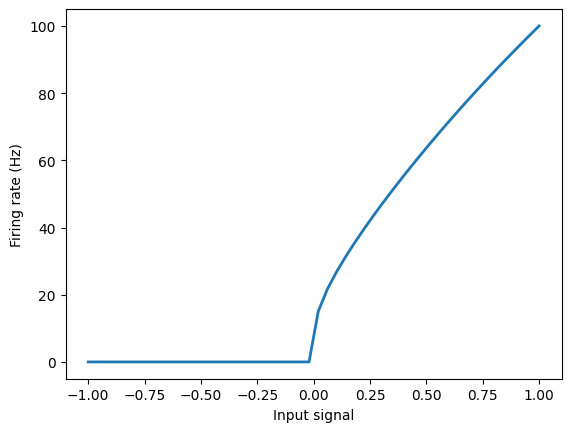

In [7]:
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders

with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(input_neuron, sim)

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")

This plot tells us that for a value just barely above zero, it will have a firing rate of about 20Hz. If we had a value nearing 1, the firing rate would be close to our max firing rate we set for the neuron, 100Hz. Anything less than zero will not fire at all.

### Okay, but how did we go from spikes to the neural representation of the value?

For a single neuron, we must first recall what a membrane action potential looks like. For each binary spike, the biological equivalent is the membrane action potential at that time step. This means you can multiply each spike by the neuron action potential shape - dependent on tau (remember that?!) and add them up. At this point, your neuron representation should be approximately the same shape as your input (for a constant value, just a straight line). If you are using one neuron in your ensemble, this should be very similar to your input signal!

We will approximate the neuron potential as a Gaussian curve (because those are easier to plot). Then we will multiply each spike by the Guassian curve and add all of those voltages together to plot our encoded input values. 

Recall Key Terms: 
1. We encode our input using spikes
2. _We then decode those spikes to determine how well the neuron approximates our input_

Here's our Gaussian curve to approximate a neuron action potential:

Text(0.5, 1.0, 'Approximated Membrane Action Potential')

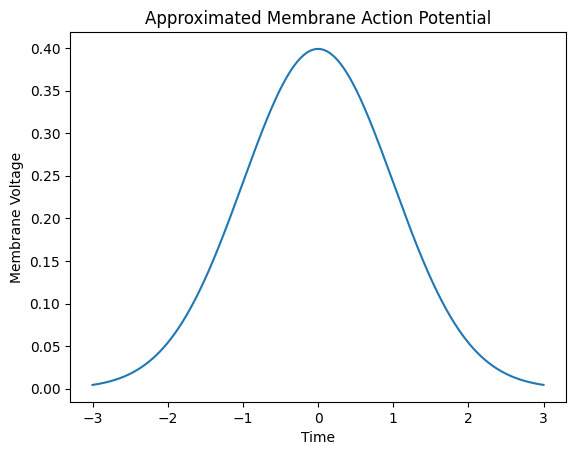

In [8]:
# x-axis ranges from -3 and 3 with .001 steps
x = np.arange(-3, 3, .001)

# plot normal distribution with mean 0 and standard deviation 1
plt.figure()
plt.plot(x, norm.pdf(x, 0, 1))
plt.xlabel("Time")
plt.ylabel("Membrane Voltage")
plt.title("Approximated Membrane Action Potential")


Now, we will find all of our spikes and multiply each by the Gaussian curve, sum them up, and get our decoded neural representation of our input value.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


Text(0.5, 1.0, 'Decoded Spikes = Neural Representation of Input')

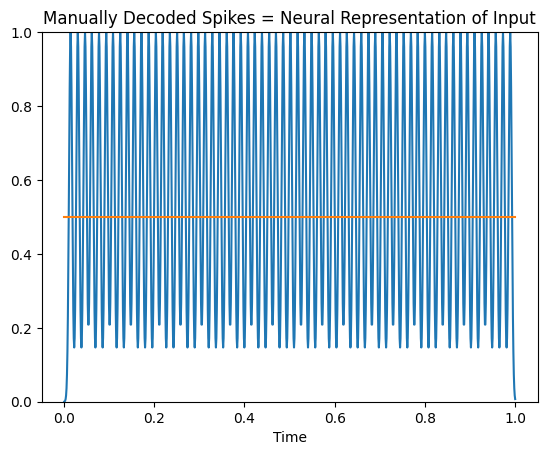

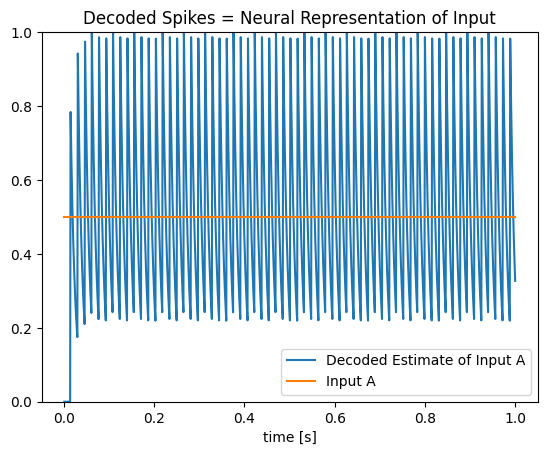

In [9]:
# the tuning curves clear everything, so run again to get our spikes
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)

t_sim1 = sim.trange() #time step every .001s
spikes_out = np.squeeze(sim.data[spikes]/1000) #gets rid of 2nd dimension length 1
#time location at which each spike occurs
spike_locs = np.unique(t_sim1*spikes_out)
spike_locs = spike_locs[1:] #get rid of spike at t=0

#funct = gauss_approx*spikes_out
gauss_approx = np.zeros(t_sim1.shape[0])
x = np.arange(0, 1, .001)
for i in spike_locs:
    temp_pdf = norm.pdf(x, i, .0035)
    gauss_approx = np.add(gauss_approx,temp_pdf)

# plot the manually decoded estimate of input A
plt.figure()
plt.plot(t_sim1, gauss_approx/np.max(gauss_approx))
plt.xlabel("Time")
plt.title("Manually Decoded Spikes = Neural Representation of Input")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.ylim(0,1)

# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A")
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")


Voila! Now you know everything about encoding and decoding a value.

**Before we move on, try hand tuning the parameters and see if you can get a single neuron to better represent our default input value (.5). Then try representing a different value and consider why it doesn't do as well as the first one you tuned (or maybe it does better?). Play with it!**


## Represent (i.e. Encode) Input Data using Ten Neurons



In [ ]:
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)

In [ ]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], lw=2)
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 1)



_this might only work for those ensembles with >1 neuron_

Nengo trains decoding weights - similar to weights of a neural network - that are used to reconstruct the input value via spiking neuron outputs.

First, we must recall what a membrane action potential looks like. For each binary spike, the biological equivalent is the membrane action potential at that time step. This means you can multiply each spike by the neuron action potential shape - dependent on tau (remember that?!) and add them up. At this point, your neuron representation should be approximately the same shape as your input (for a constant value, just a straight line). To get the value to be comparable to your input, you must then multiply by the decoding weight. This will result in your decoded output signal, which ideally looks very similar to your input signal! 

Let's get our decoding values by probing our model. Because weights are trained values between neurons, we need to probe our connections.

In [ ]:
with model:
    # decoder values are constant, so we only need to grab the weight at one timestep
    decoder_probe = nengo.Probe(inp_conn, "weights", sample_every=1)

# run simulation again to capture the decoder value
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(1)